In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
import glob

In [3]:
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['font.size'] = 12

In [4]:
def read_markdown_files(folder_path):
    md_files = glob.glob(os.path.join(folder_path, "**/*.md"), recursive=True)
    md_files += glob.glob(os.path.join(folder_path, "**/*.mdx"), recursive=True)
    
    documents = []
    
    for file_path in md_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                content = file.read()
                
            file_name = os.path.basename(file_path)
            relative_path = os.path.relpath(file_path, folder_path)
            
            documents.append({
                'file_name': file_name,
                'file_path': relative_path,
                'content': content,
                'file_size': len(content),
                'directory': os.path.dirname(relative_path)
            })
        except Exception as e:
            print(f"Ошибка чтения файла {file_path}: {e}")
    
    return pd.DataFrame(documents)

In [6]:
def extract_markdown_sections(text):
    headers = re.findall(r'^(#{1,6})\s*(.*)$', text, re.MULTILINE)
    code_blocks = re.findall(r'```.*?```', text, re.DOTALL)
    links = re.findall(r'\[([^\]]+)\]\(([^)]+)\)', text)
    images = re.findall(r'!\[([^\]]*)\]\(([^)]+)\)', text)
    
    return {
        'headers': headers,
        'code_blocks_count': len(code_blocks),
        'links_count': len(links),
        'images_count': len(images),
        'headers_count': len(headers)
    }

In [8]:
df = read_markdown_files('dataset')

In [44]:
print(f"Всего файлов: {len(df)}")
print(f"Общий объем: {df['file_size'].sum() / 1024 / 1024:.2f} MB")
print(f"Средний размер файла: {df['file_size'].mean() / 1024:.2f} KB")
print(f"Медианный размер файла: {df['file_size'].median() / 1024:.2f} KB")
print(f"Среднее количество слов: {df['word_count'].mean():.0f}")
print(f"Среднее количество заголовков: {df['headers_count'].mean():.1f}")
print(f"Среднее количество блоков кода: {df['code_blocks_count'].mean():.1f}")

print(f"\nРаспределение размеров:")
print(f"Min: {df['file_size'].min() / 1024:.1f} KB")
print(f"Max: {df['file_size'].max() / 1024:.1f} KB")
print(f"Std: {df['file_size'].std() / 1024:.1f} KB")

Всего файлов: 3089
Общий объем: 18.49 MB
Средний размер файла: 6.13 KB
Медианный размер файла: 1.25 KB
Среднее количество слов: 452
Среднее количество заголовков: 0.7
Среднее количество блоков кода: 1.6

Распределение размеров:
Min: 0.0 KB
Max: 411.5 KB
Std: 19.9 KB


In [12]:
def clean_markdown_text(text):
    text = re.sub(r'```.*?```', '', text, flags=re.DOTALL)
    text = re.sub(r'`[^`]*`', '', text)
    text = re.sub(r'^#{1,6}\s*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\[([^\]]+)\]\([^)]+\)', r'\1', text)
    text = re.sub(r'!\[([^\]]*)\]\([^)]+\)', '', text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\n\s*\n', '\n\n', text)
    
    return text.strip()

In [13]:
df['content_clean'] = df['content'].apply(clean_markdown_text)
df['content_length'] = df['content_clean'].str.len()
df['word_count'] = df['content_clean'].str.split().str.len()

In [15]:
section_info = df['content'].apply(extract_markdown_sections)
df = pd.concat([df, section_info.apply(pd.Series)], axis=1)

In [16]:
df

,file_name,file_path,content,file_size,directory,content_clean,content_length,word_count,headers,code_blocks_count,links_count,images_count,headers_count
0,torch.accelerator.current_accelerator.md,dataset\accelerator\torch.accelerator.current_...,torch.accelerator.current_accelerator \n======...,1840,dataset\accelerator,torch.accelerator.current_accelerator \n======...,1190,118,[],1,9,0,0
1,torch.accelerator.current_device_idx.md,dataset\accelerator\torch.accelerator.current_...,torch.accelerator.current_device_idx \n=======...,552,dataset\accelerator,torch.accelerator.current_device_idx \n=======...,361,34,[],0,3,0,0
2,torch.accelerator.current_device_index.md,dataset\accelerator\torch.accelerator.current_...,torch.accelerator.current_device_index \n=====...,560,dataset\accelerator,torch.accelerator.current_device_index \n=====...,369,34,[],0,3,0,0
3,torch.accelerator.current_stream.md,dataset\accelerator\torch.accelerator.current_...,torch.accelerator.current_stream \n===========...,920,dataset\accelerator,torch.accelerator.current_stream \n===========...,698,66,[],0,5,0,0
4,torch.accelerator.device_count.md,dataset\accelerator\torch.accelerator.device_c...,torch.accelerator.device_count \n=============...,878,dataset\accelerator,torch.accelerator.device_count \n=============...,592,72,[],0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,torch.xpu.set_rng_state_all.md,dataset\xpu\torch.xpu.set_rng_state_all.md,torch.xpu.set_rng_state_all \n================...,418,dataset\xpu,torch.xpu.set_rng_state_all \n================...,342,33,[],0,1,0,0
3085,torch.xpu.set_stream.md,dataset\xpu\torch.xpu.set_stream.md,torch.xpu.set_stream \n=======================...,549,dataset\xpu,torch.xpu.set_stream \n=======================...,395,53,[],0,2,0,0
3086,torch.xpu.stream.md,dataset\xpu\torch.xpu.stream.md,torch.xpu.stream \n===========================...,561,dataset\xpu,torch.xpu.stream \n===========================...,333,40,[],0,3,0,0
3087,torch.xpu.StreamContext.md,dataset\xpu\torch.xpu.StreamContext.md,StreamContext \n==============================...,537,dataset\xpu,StreamContext \n==============================...,391,51,[],0,2,0,0


In [17]:
all_headers = []
for headers in df['headers']:
    all_headers.extend([(len(h[0]), h[1].strip()) for h in headers])

if all_headers:
    headers_df = pd.DataFrame(all_headers, columns=['level', 'text'])
else:
    headers_df = pd.DataFrame(columns=['level', 'text'])

In [18]:
headers_df

,level,text
0,3,Creation Ops
1,3,"Indexing, Slicing, Joining, Mutating Ops"
2,3,In-place random sampling
3,3,Quasi-random sampling
4,3,Constants
...,...,...
2239,1,allowed:
2240,1,disallowed (RuntimeError: result type can't be...
2241,1,Then automatically generate backend-related at...
2242,1,"This will work, assuming that you've implement..."


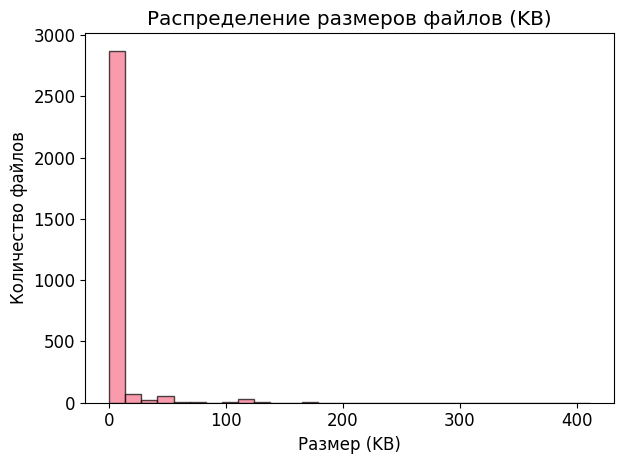

In [19]:
plt.hist(df['file_size'] / 1024, bins=30, alpha=0.7, edgecolor='black')
plt.title('Распределение размеров файлов (KB)')
plt.xlabel('Размер (KB)')
plt.ylabel('Количество файлов')
plt.tight_layout()
plt.show()

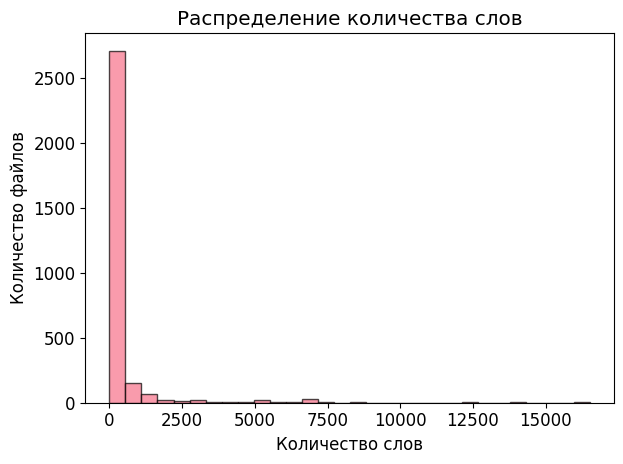

In [20]:
plt.hist(df['word_count'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Распределение количества слов')
plt.xlabel('Количество слов')
plt.ylabel('Количество файлов')
plt.tight_layout()
plt.show()

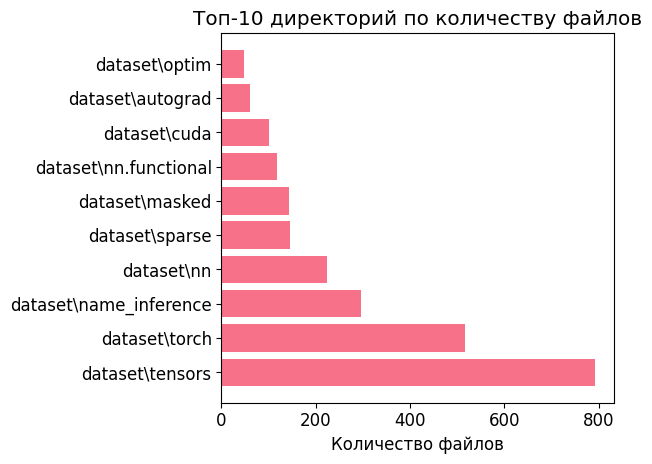

In [21]:
top_dirs = df['directory'].value_counts().head(10)
plt.barh(range(len(top_dirs)), top_dirs.values)
plt.yticks(range(len(top_dirs)), [d[:30] + '...' if len(d) > 30 else d for d in top_dirs.index])
plt.title('Топ-10 директорий по количеству файлов')
plt.xlabel('Количество файлов')
plt.tight_layout()
plt.show()

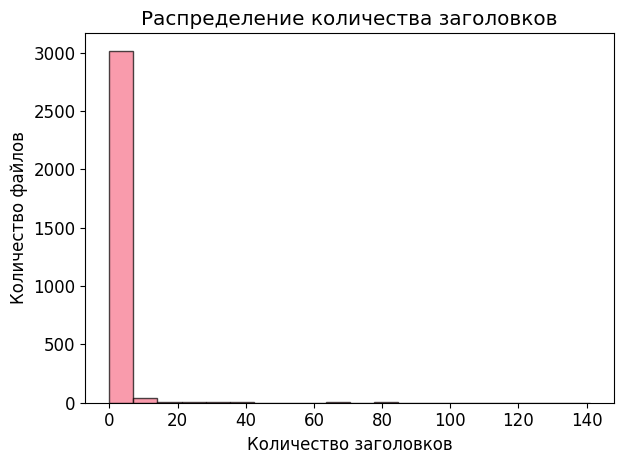

In [22]:
plt.hist(df['headers_count'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Распределение количества заголовков')
plt.xlabel('Количество заголовков')
plt.ylabel('Количество файлов')
plt.tight_layout()
plt.show()

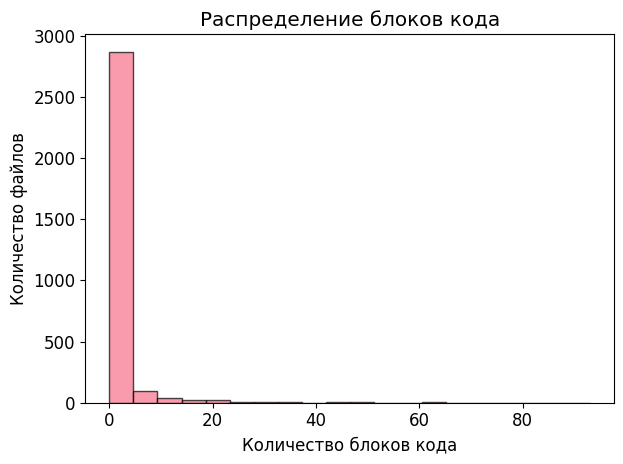

In [23]:
plt.hist(df['code_blocks_count'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Распределение блоков кода')
plt.xlabel('Количество блоков кода')
plt.ylabel('Количество файлов')
plt.tight_layout()
plt.show()

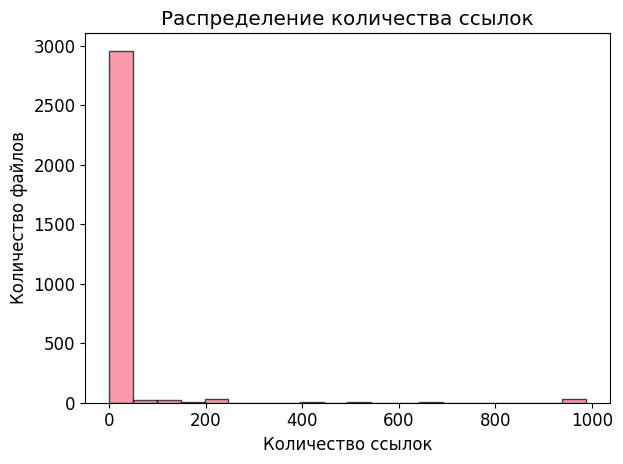

In [24]:
plt.hist(df['links_count'], bins=20, alpha=0.7, edgecolor='black')
plt.title('Распределение количества ссылок')
plt.xlabel('Количество ссылок')
plt.ylabel('Количество файлов')
plt.tight_layout()
plt.show()

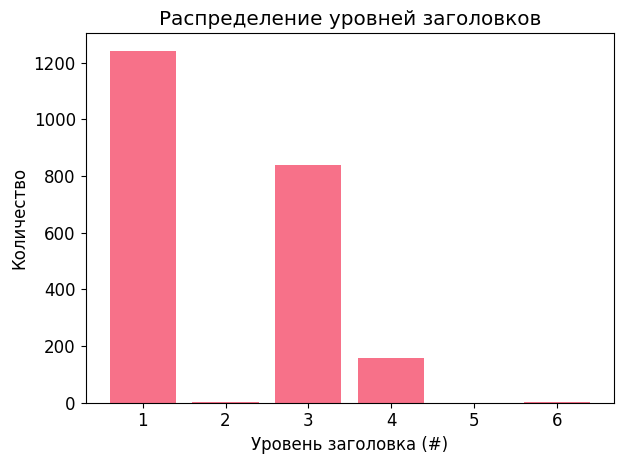

In [25]:
header_levels = headers_df['level'].value_counts().sort_index()
plt.bar(header_levels.index, header_levels.values)
plt.title('Распределение уровней заголовков')
plt.xlabel('Уровень заголовка (#)')
plt.ylabel('Количество')
plt.tight_layout()
plt.show()

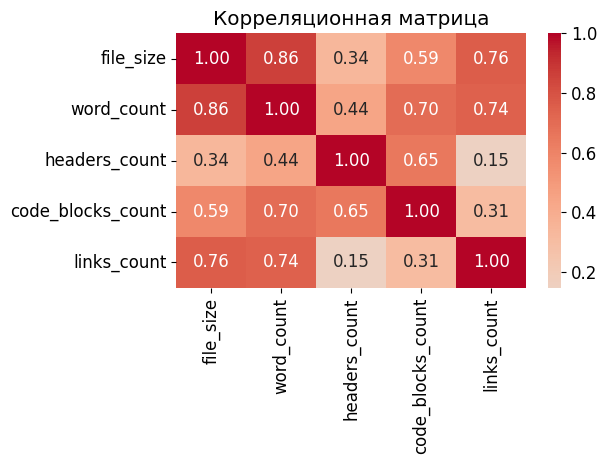

In [26]:
numeric_cols = ['file_size', 'word_count', 'headers_count', 'code_blocks_count', 'links_count']
correlation_matrix = df[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Корреляционная матрица')
plt.tight_layout()
plt.show()

In [27]:
print("\nСамые большие файлы (по размеру):")
top_size = df.nlargest(5, 'file_size')[['file_name', 'file_size', 'directory']]
for _, row in top_size.iterrows():
    print(f"  {row['file_name']} ({row['file_size'] / 1024:.1f} KB) - {row['directory']}")


Самые большие файлы (по размеру):
  jit_builtin_functions.md (411.5 KB) - dataset\jit
  programming_model.skipped_functions.md (228.7 KB) - dataset\torch.compiler
  quantization-backend-configuration.md (182.8 KB) - dataset\quantization
  distributions.md (175.9 KB) - dataset\torch
  distributed.md (168.3 KB) - dataset\distributed.fsdp.fully_shard


In [28]:
print("\nФайлы с наибольшим количеством слов:")
top_words = df.nlargest(5, 'word_count')[['file_name', 'word_count', 'directory']]
for _, row in top_words.iterrows():
    print(f"  {row['file_name']} ({row['word_count']} слов) - {row['directory']}")


Файлы с наибольшим количеством слов:
  distributed.md (16525 слов) - dataset\distributed.fsdp.fully_shard
  distributed.md (16525 слов) - dataset\distributed.optim
  distributed.md (16525 слов) - dataset\distributed.tensor
  distributed.md (16525 слов) - dataset\fsdp
  distributed.md (16525 слов) - dataset\rpc


In [31]:
print("\nФайлы с наибольшим количеством заголовков:")
top_headers = df.nlargest(5, 'headers_count')[['file_name', 'headers_count', 'directory']]
for _, row in top_headers.iterrows():
    print(f"  {row['file_name']} ({row['headers_count']} заголовков) - {row['directory']}")


Файлы с наибольшим количеством заголовков:
  quantization.md (141 заголовков) - dataset\nn
  jit_language_reference_v2.md (83 заголовков) - dataset\jit
  cuda.md (81 заголовков) - dataset\autograd
  cuda.md (81 заголовков) - dataset\backends
  cuda.md (81 заголовков) - dataset\cuda


In [32]:
all_text = ' '.join(df['content_clean'].dropna().astype(str))

In [33]:
def get_top_words(text, n=25, exclude_common=True):
    words = re.findall(r'\b[a-zA-Z]{3,}\b', text.lower())
    
    # Расширенный список стоп-слов
    stop_words = {
        'the', 'and', 'for', 'are', 'with', 'this', 'that', 'from', 'have', 'has', 
        'was', 'were', 'will', 'your', 'you', 'their', 'there', 'what', 'which',
        'when', 'where', 'how', 'why', 'then', 'than', 'but', 'not', 'they', 'been',
        'can', 'could', 'should', 'would', 'may', 'might', 'must', 'shall',
        'also', 'very', 'just', 'more', 'most', 'some', 'such', 'only', 'about',
        'into', 'through', 'during', 'before', 'after', 'between', 'under',
        'while', 'because', 'until', 'unless', 'although', 'though', 'whether',
        'while', 'each', 'both', 'either', 'neither', 'none', 'any', 'all'
    }
    
    # Дополнительные технические стоп-слова
    tech_stop_words = {
        'function', 'method', 'class', 'module', 'package', 'library',
        'example', 'following', 'below', 'above', 'section', 'chapter',
        'note', 'important', 'warning', 'caution', 'see', 'using', 'use'
    }
    
    all_stop_words = stop_words.union(tech_stop_words)
    
    if exclude_common:
        words = [word for word in words if word not in all_stop_words]
    
    return Counter(words).most_common(n)

In [34]:
top_words = get_top_words(all_text)

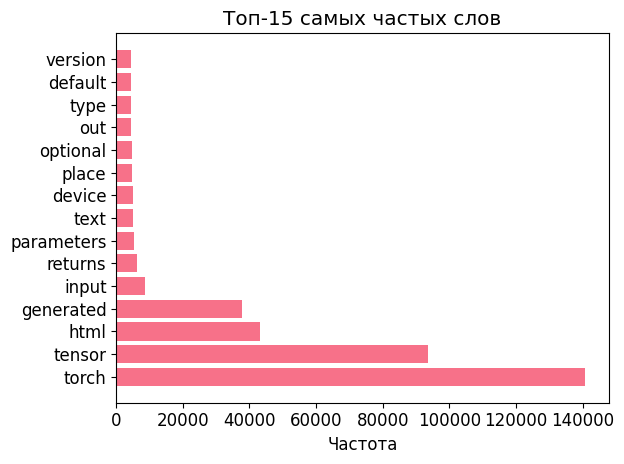

In [35]:
words, counts = zip(*top_words[:15])
plt.barh(range(len(words)), counts)
plt.yticks(range(len(words)), words)
plt.title('Топ-15 самых частых слов')
plt.xlabel('Частота')
plt.tight_layout()
plt.show()

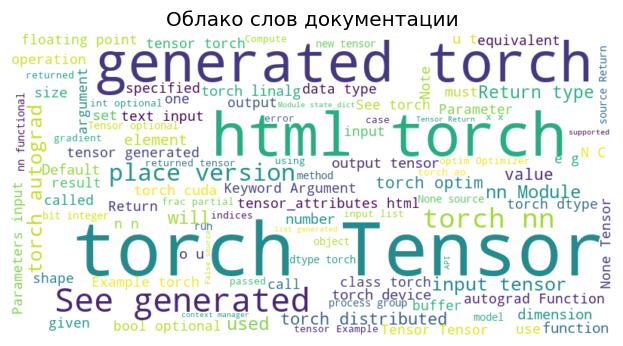

In [36]:
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white',
    max_words=100
).generate(all_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Облако слов документации')

plt.tight_layout()
plt.show()

In [37]:
print(f"Общее количество блоков кода: {df['code_blocks_count'].sum()}")
print(f"Общее количество ссылок: {df['links_count'].sum()}")
print(f"Общее количество изображений: {df['images_count'].sum()}")

Общее количество блоков кода: 4990
Общее количество ссылок: 70416
Общее количество изображений: 299


In [38]:
dir_stats = df.groupby('directory').agg({
    'file_name': 'count',
    'file_size': ['sum', 'mean'],
    'word_count': 'mean',
    'headers_count': 'mean',
    'code_blocks_count': 'mean'
}).round(2)

In [39]:
dir_stats.columns = ['file_count', 'total_size', 'avg_file_size', 'avg_word_count', 'avg_headers', 'avg_code_blocks']
dir_stats = dir_stats.sort_values('file_count', ascending=False)

In [40]:
dir_stats.head(10)

,file_count,total_size,avg_file_size,avg_word_count,avg_headers,avg_code_blocks
directory,,,,,,
dataset\tensors,793,1134416,1430.54,110.99,0.07,0.48
dataset\torch,516,1731077,3354.80,241.95,0.15,1.09
dataset\name_inference,296,342487,1157.05,85.66,0.06,0.49
dataset\nn,223,1981008,8883.44,533.42,0.67,1.09
dataset\sparse,145,480431,3313.32,243.85,0.17,0.66
dataset\masked,143,486353,3401.07,218.56,0.09,1.07
dataset\nn.functional,117,328120,2804.44,201.61,0.01,0.24
dataset\cuda,101,264632,2620.12,233.44,1.00,0.91
dataset\autograd,60,632270,10537.83,895.82,2.57,2.58
